<a href="https://colab.research.google.com/github/codml/AI_jupyter/blob/main/SpyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

torch.__version__

'2.1.0+cu121'

100%|██████████| 26421880/26421880 [00:02<00:00, 12220528.35it/s]


Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205001.18it/s]


Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3866829.08it/s]


Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5982897.48it/s]
<ipython-input-3-062a45ee1435>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array(train_dataset.data, dtype=np.float)


Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



<ipython-input-3-062a45ee1435>:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = np.array(test_dataset.data, dtype=np.float)
<ipython-input-3-062a45ee1435>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train

(-0.5, 27.5, 27.5, -0.5)

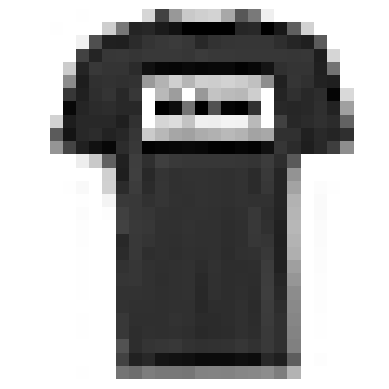

In [3]:
# The coarse network structure is dicated by the Fashion MNIST dataset.
nb_inputs = 28*28
nb_hidden = 100
nb_outputs = 10

time_step = 1e-3
nb_steps = 100

batch_size = 256

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0], -1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int)
y_test = np.array(test_dataset.targets, dtype=np.int)

# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

In [28]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value
    tmax -- The maximum time returned
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time, neuron) tuples
        y: The labels
    """

    labels_ = np.array(y, dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3)]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].entend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))